<a href="https://www.kaggle.com/code/yasinsoylu123/pfizer-stock-time-series-and-lstm?scriptVersionId=116600343" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #Plotting
%matplotlib inline
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,10) #Make the plots bigger by default
plt.rcParams["lines.linewidth"] = 2 #Setting the default line width
plt.style.use("ggplot")

from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.callbacks import ModelCheckpoint, EarlyStopping , ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error

import warnings
import warnings
warnings.filterwarnings('ignore')


import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
df = pd.read_csv('../input/pfizer-stock-data/PFE.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1972-06-01,0.000000,0.815346,0.802993,0.815346,0.171287,2458771
1,1972-06-02,0.815346,0.817817,0.802993,0.805463,0.169211,1613885
2,1972-06-05,0.805463,0.807934,0.798051,0.802993,0.168692,2585251
3,1972-06-06,0.802993,0.825229,0.800522,0.820288,0.172325,2347469
4,1972-06-07,0.820288,0.820288,0.807934,0.820288,0.172325,1032077


In [3]:
df.isnull().sum()


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
fig=make_subplots(specs=[[{"secondary_y":False}]])
fig.add_trace(go.Scatter(x=df['Date'],y=df['Open'].rolling(window=7).mean(),name="PFIZER"),secondary_y=False,)
fig.update_layout(autosize=False,width=900,height=500,title_text="PFIZER")
fig.update_xaxes(title_text="year")
fig.update_yaxes(title_text="prices",secondary_y=False)
fig.show()

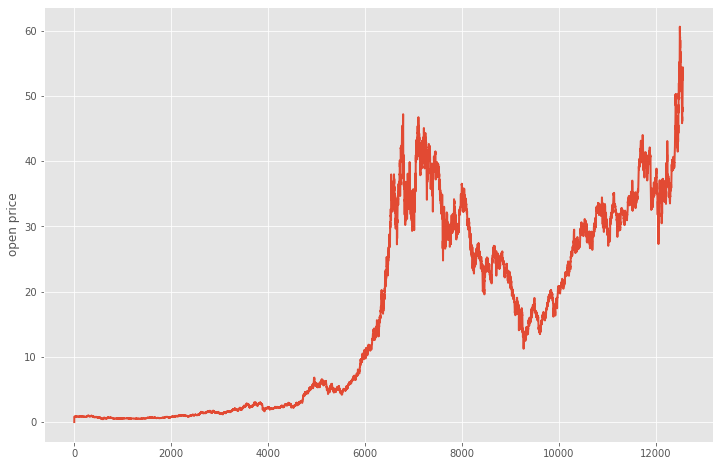

In [5]:
df['Open'].plot(figsize=(12,8));
plt.ylabel("open price");

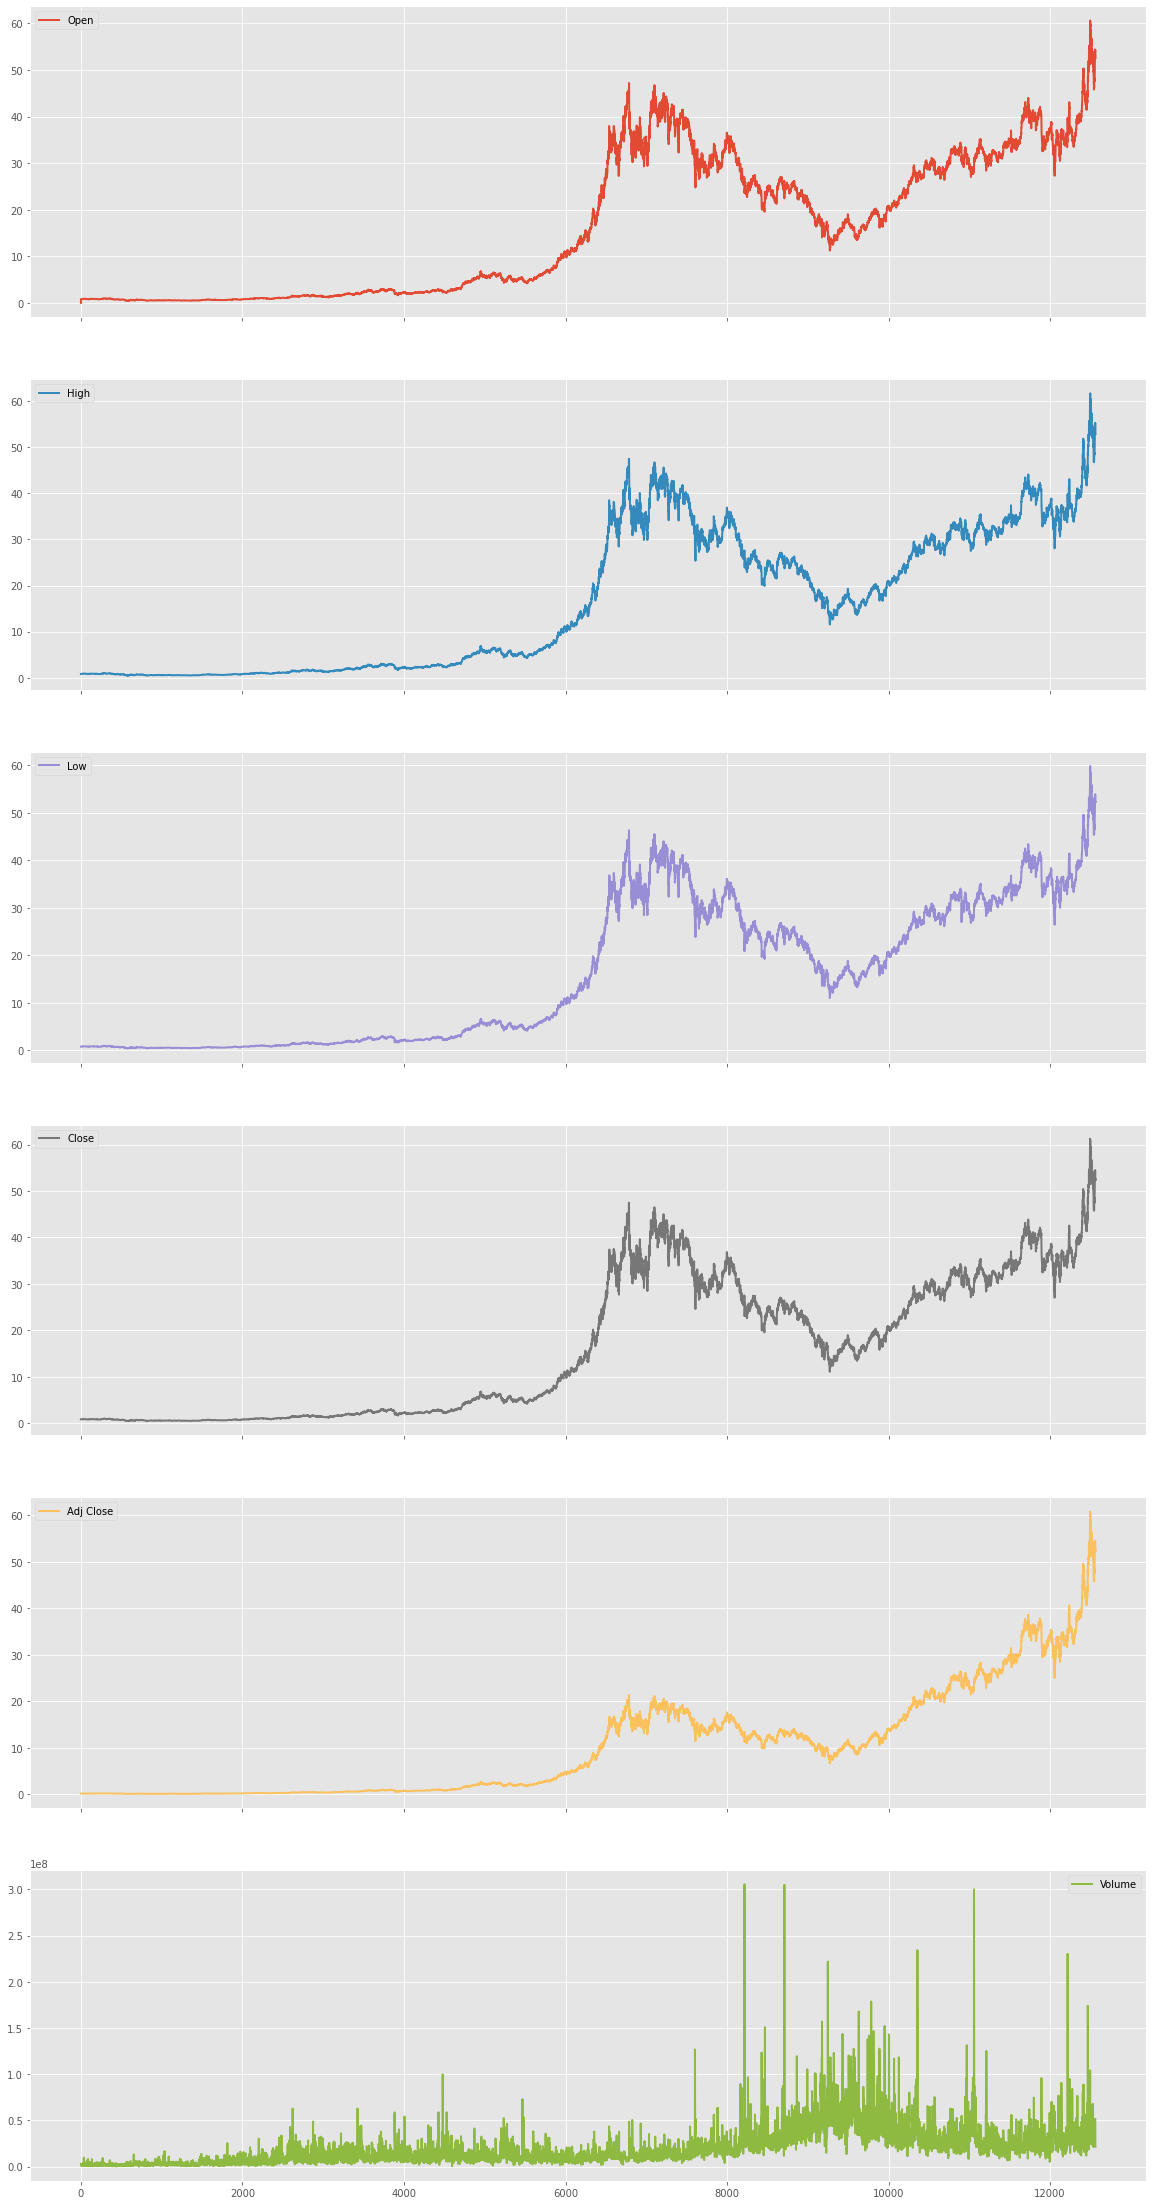

In [6]:
df.plot(subplots=True, figsize=(20, 40))
plt.show()

In [7]:
df["Date"]=pd.to_datetime(df.Date,dayfirst=True)
df.set_index("Date",inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1972-06-01,0.000000,0.815346,0.802993,0.815346,0.171287,2458771
1972-06-02,0.815346,0.817817,0.802993,0.805463,0.169211,1613885
1972-06-05,0.805463,0.807934,0.798051,0.802993,0.168692,2585251
1972-06-06,0.802993,0.825229,0.800522,0.820288,0.172325,2347469
1972-06-07,0.820288,0.820288,0.807934,0.820288,0.172325,1032077
...,...,...,...,...,...,...
2022-03-18,54.380001,55.000000,53.709999,54.509998,54.509998,51766200
2022-03-21,54.240002,55.299999,53.900002,54.189999,54.189999,34592500
2022-03-22,54.200001,54.320000,52.500000,53.040001,53.040001,32253600


In [8]:
df=df.asfreq("d")
df = df.fillna(method  = "bfill")

In [9]:
df['Total Pos'] = df.sum(axis=1)


Text(0.5, 1.0, 'Total Portfolio Value')

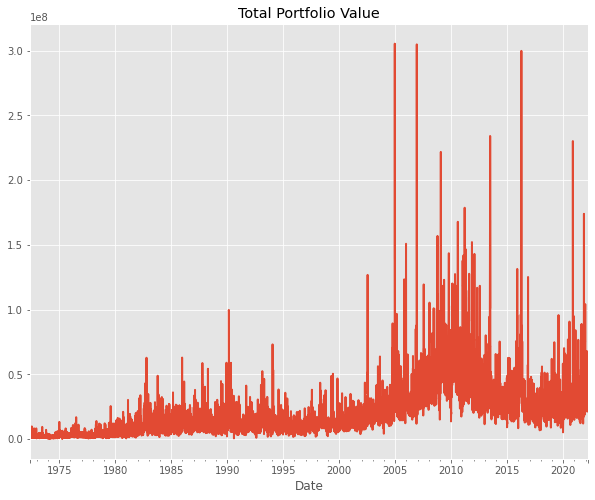

In [10]:
df['Total Pos'].plot(figsize=(10,8))
plt.title('Total Portfolio Value')

In [11]:
df['Daily Return'] = df['Total Pos'].pct_change(1)


In [12]:
df['Daily Return'].mean()


49.6646945831398

<AxesSubplot:ylabel='Density'>

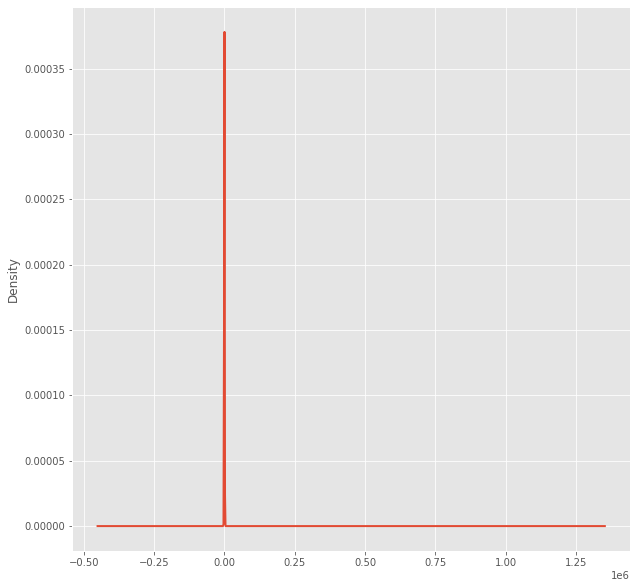

In [13]:
df['Daily Return'].plot(kind='kde')


In [14]:
SR = df['Daily Return'].mean()/df['Daily Return'].std()


<AxesSubplot:xlabel='Date'>

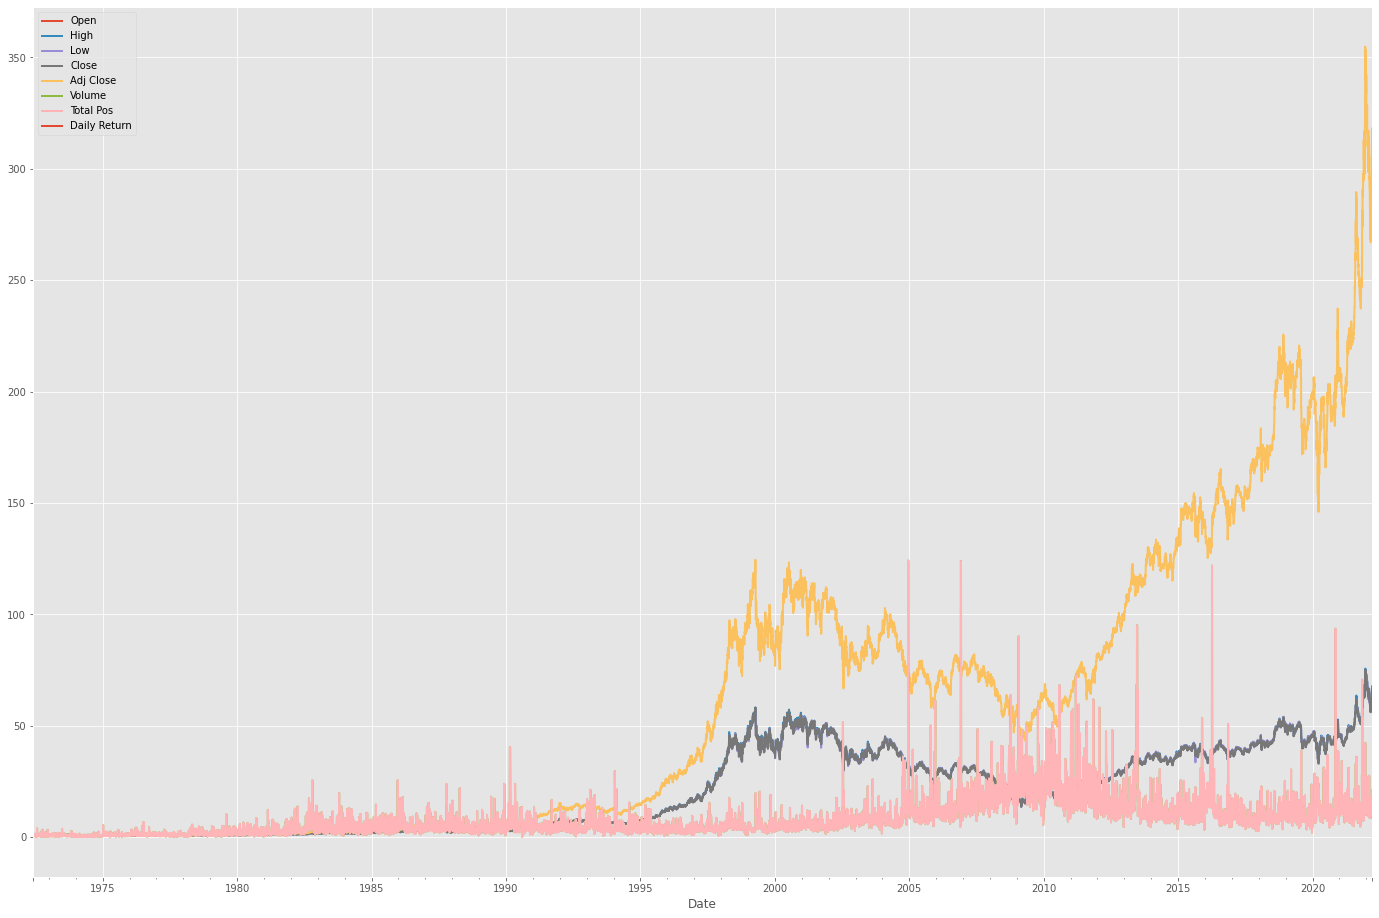

In [15]:
all_plot = df/df.iloc[0]
all_plot.plot(figsize=(24,16))

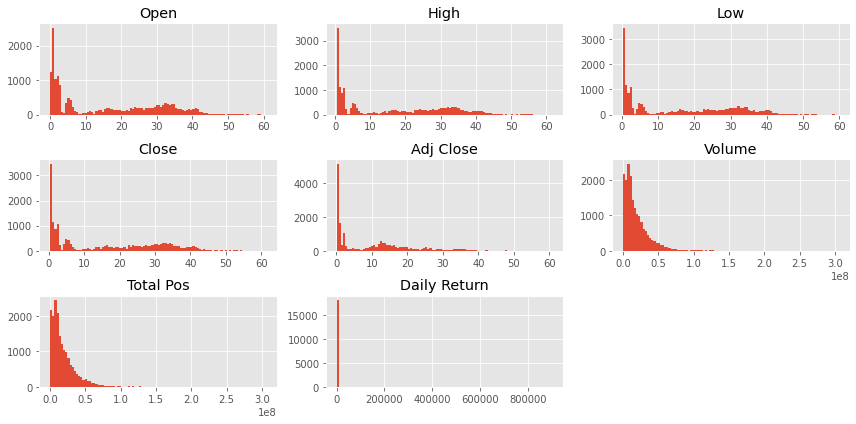

In [16]:
df.hist(bins=100,figsize=(12,6));
plt.tight_layout()

In [17]:
df.resample(rule='A').mean()


,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return
Date,,,,,,,,
1972-12-31,0.841566,0.852765,0.837375,0.845111,0.178063,2.168482e+06,2.168485e+06,0.207249
1973-12-31,0.866744,0.875064,0.857078,0.866156,0.184843,1.985909e+06,1.985913e+06,0.118578
1974-12-31,0.656176,0.667386,0.645386,0.654788,0.142314,1.551858e+06,1.551860e+06,0.142403
1975-12-31,0.592519,0.601048,0.582006,0.590644,0.131776,2.534507e+06,2.534509e+06,2471.519715
1976-12-31,0.557929,0.565200,0.550659,0.558031,0.128341,3.270137e+06,3.270139e+06,0.097074
1977-12-31,0.528868,0.533796,0.523439,0.528658,0.125765,2.503847e+06,2.503849e+06,0.143824
1978-12-31,0.626737,0.633689,0.619487,0.627495,0.155279,3.893422e+06,3.893424e+06,0.146120
1979-12-31,0.659324,0.665443,0.653144,0.659893,0.169675,4.197043e+06,4.197046e+06,0.179677
1980-12-31,0.821084,0.829955,0.812565,0.821658,0.219178,4.853819e+06,4.853822e+06,0.206077


[]

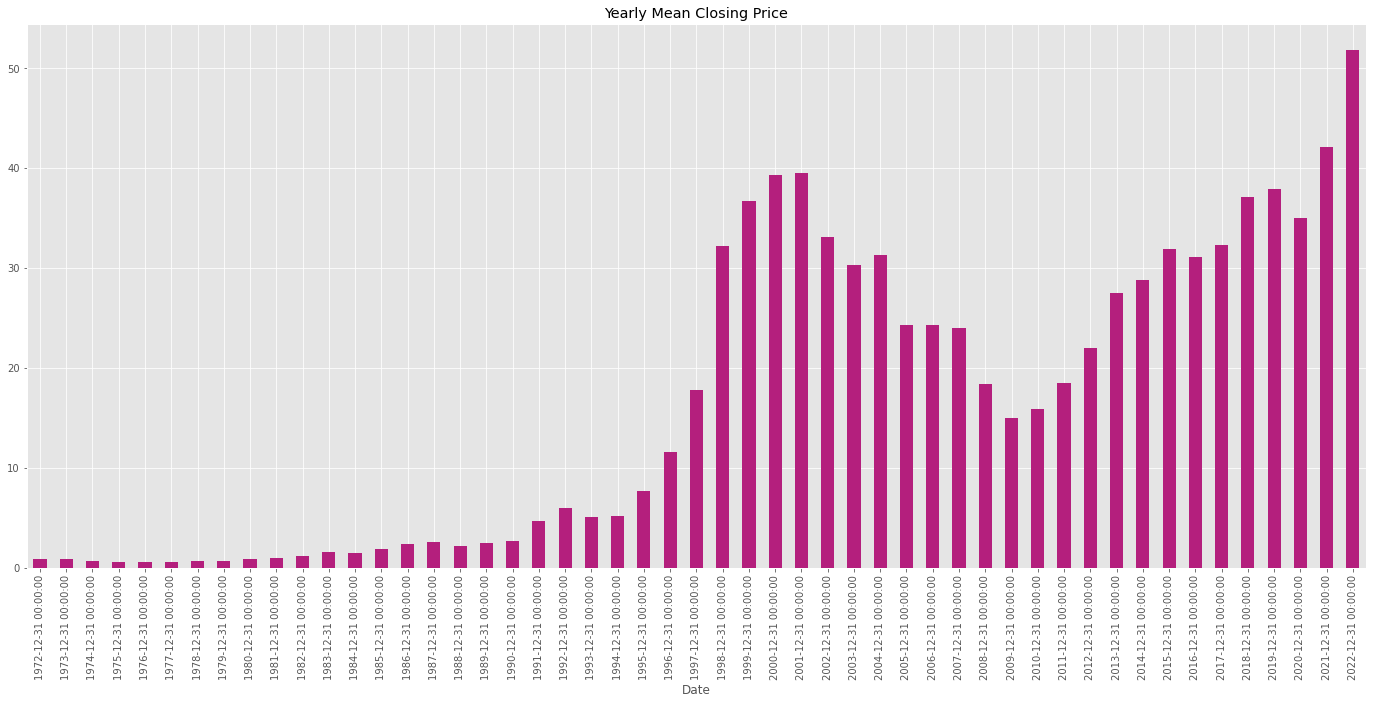

In [18]:
title = 'Yearly Mean Closing Price'
df['Open'].resample('A').mean().plot.bar(title=title,color=['#b41f7d'], figsize=(24,10));
plt.plot(figsize=(30,40))

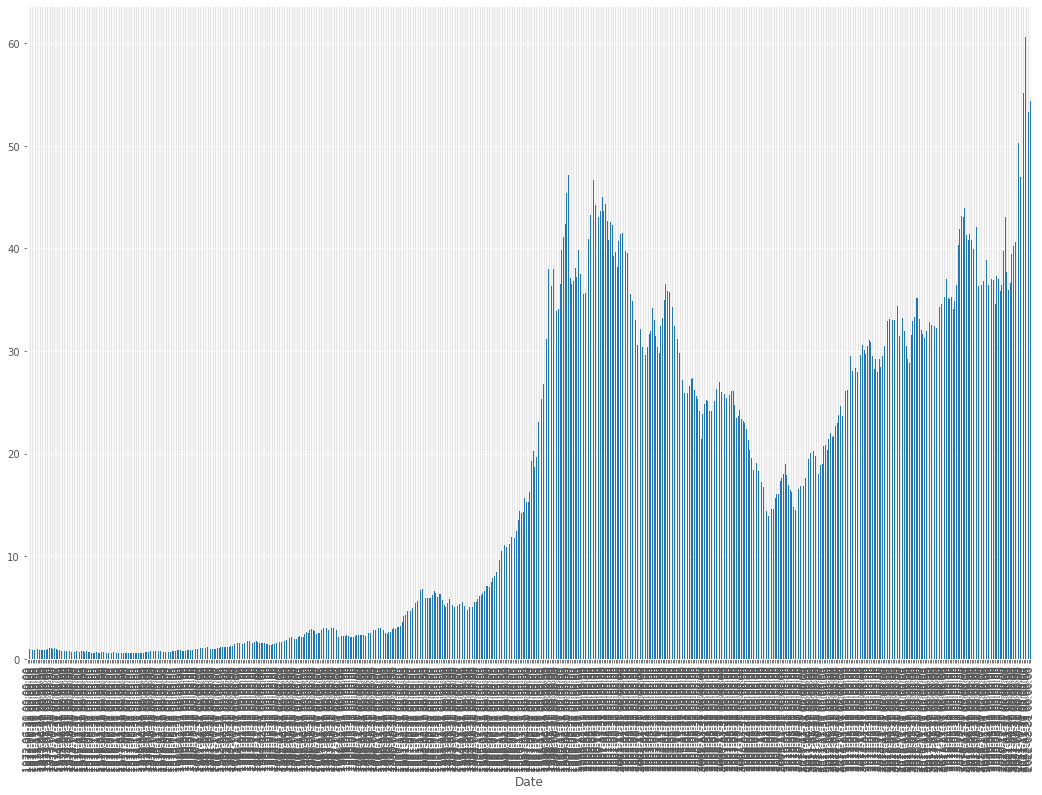

In [19]:
df['Open'].resample('M').max().plot.bar(figsize=(18,12),color='#1f77b4');


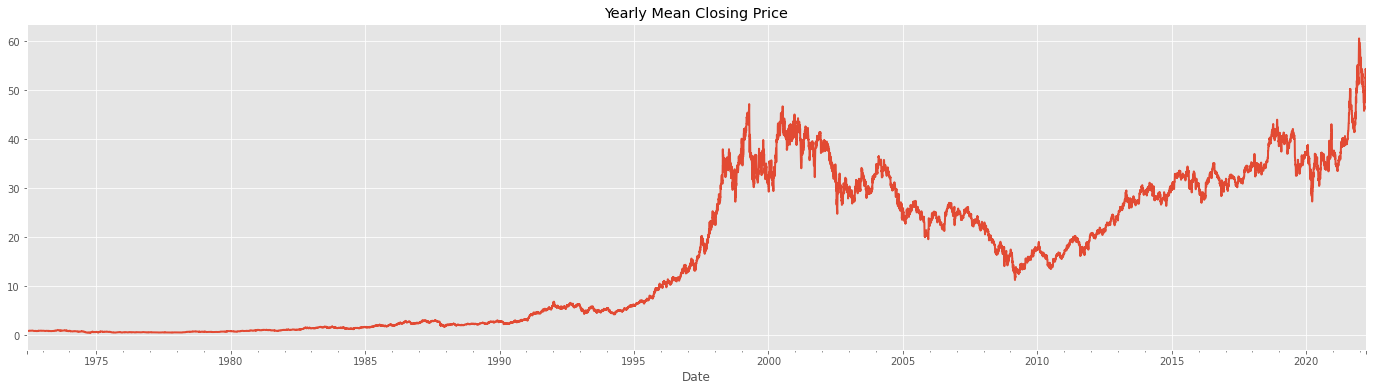

In [20]:
ax = df['Open'].plot(figsize=(24,6),title=title)


In [21]:
df['6-month-SMA'] = df['Open'].rolling(window=6).mean()
df['12-month-SMA'] = df['Open'].rolling(window=12).mean()
df['2-month-SMA'] = df['Open'].rolling(window=2).mean()

In [22]:
df.head(13)


,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA
Date,,,,,,,,,,,
1972-06-01,0.000000,0.815346,0.802993,0.815346,0.171287,2458771.0,2.458774e+06,NaN,NaN,NaN,NaN
1972-06-02,0.815346,0.817817,0.802993,0.805463,0.169211,1613885.0,1.613888e+06,-0.343621,NaN,NaN,0.407673
1972-06-03,0.805463,0.807934,0.798051,0.802993,0.168692,2585251.0,2.585254e+06,0.601879,NaN,NaN,0.810404
1972-06-04,0.805463,0.807934,0.798051,0.802993,0.168692,2585251.0,2.585254e+06,0.000000,NaN,NaN,0.805463
1972-06-05,0.805463,0.807934,0.798051,0.802993,0.168692,2585251.0,2.585254e+06,0.000000,NaN,NaN,0.805463
1972-06-06,0.802993,0.825229,0.800522,0.820288,0.172325,2347469.0,2.347472e+06,-0.091976,0.672455,NaN,0.804228
1972-06-07,0.820288,0.820288,0.807934,0.820288,0.172325,1032077.0,1.032080e+06,-0.560344,0.809169,NaN,0.811640
1972-06-08,0.820288,0.822759,0.815346,0.815346,0.171287,1067491.0,1.067494e+06,0.034313,0.809993,NaN,0.820288
1972-06-09,0.815346,0.822759,0.815346,0.820288,0.172325,1563293.0,1.563296e+06,0.464454,0.811640,NaN,0.817817


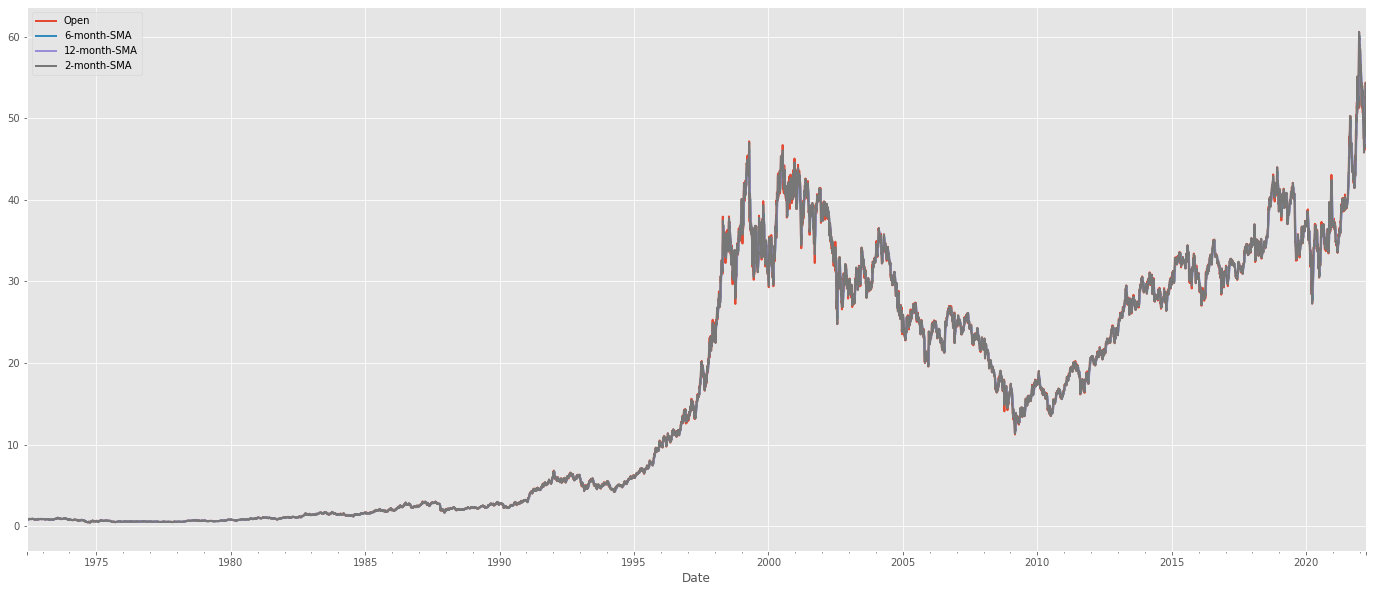

In [23]:
df[["Open","6-month-SMA","12-month-SMA","2-month-SMA"]].plot(figsize=(24,10));


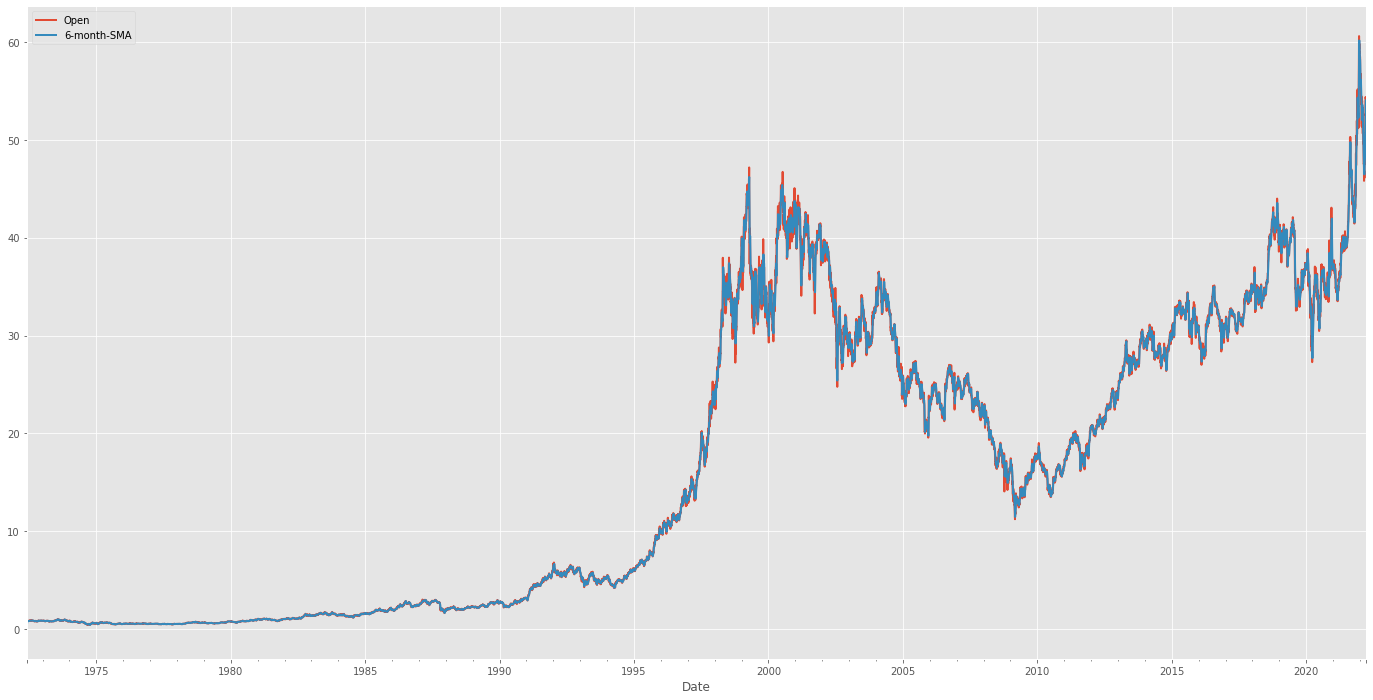

In [24]:
df[["Open","6-month-SMA"]].plot(figsize=(24,12));


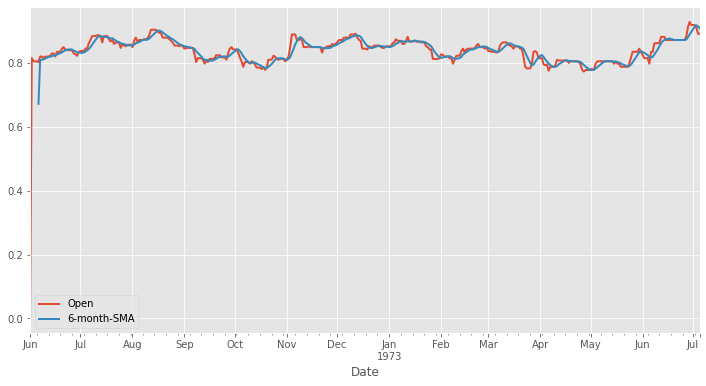

In [25]:
df[['Open','6-month-SMA']].iloc[:400].plot(figsize=(12,6)).autoscale(axis='x',tight=True);


In [26]:
df['EWMA12'] = df['Open'].ewm(span=14,adjust=True).mean()


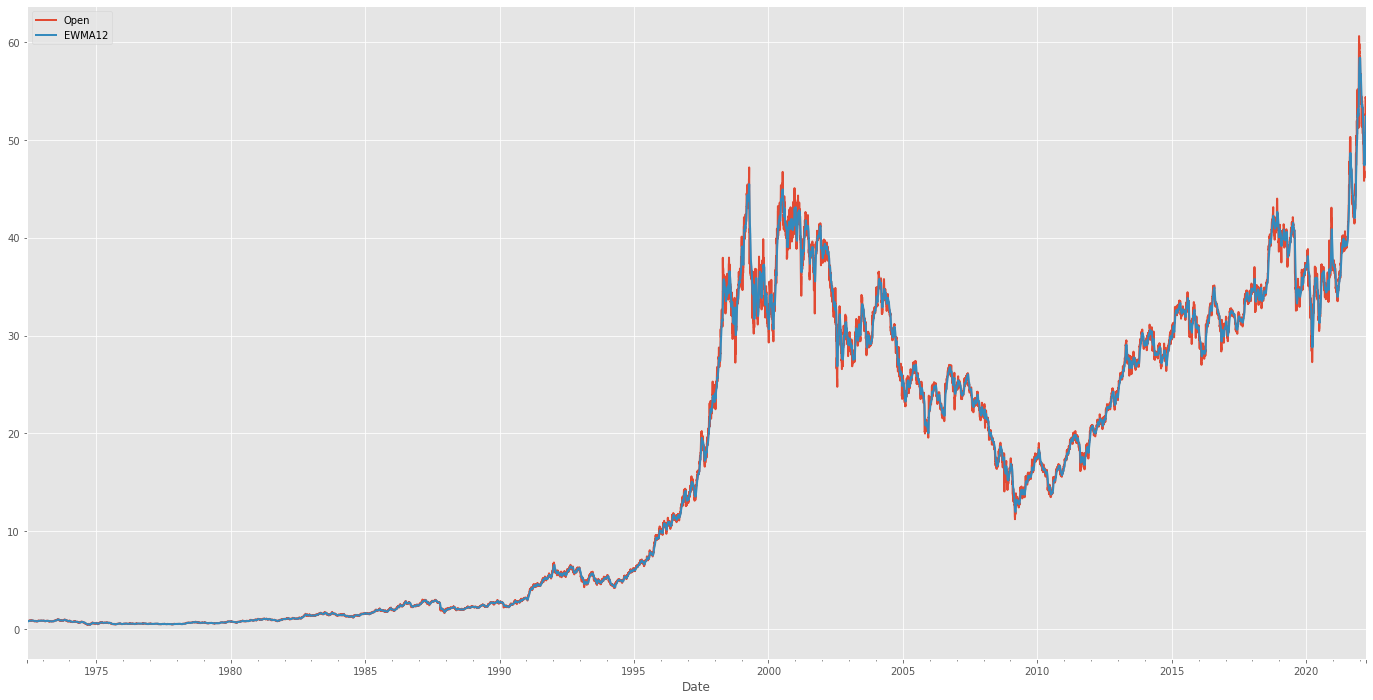

In [27]:
df[['Open','EWMA12']].plot(figsize=(24,12));


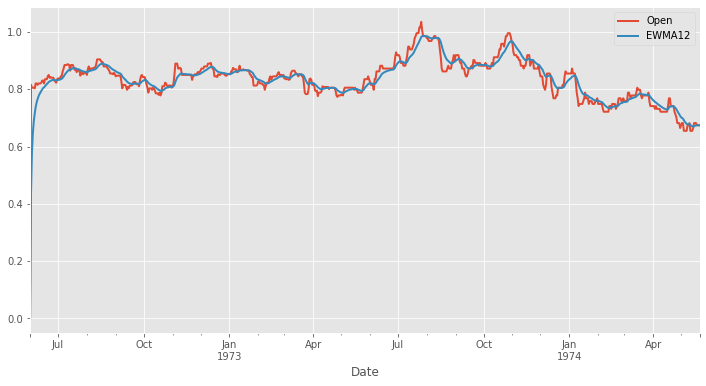

In [28]:
df[['Open','EWMA12']].iloc[:720].plot(figsize=(12,6)).autoscale(axis='x',tight=True);


In [29]:
span = 8
alpha = 2/(span+1);

In [30]:
df['EWMA12'] = df['Open'].ewm(alpha=alpha,adjust=False).mean()


In [31]:
model=SimpleExpSmoothing(df["Open"])


In [32]:
model.fit(smoothing_level=alpha,optimized=False)


In [33]:
fitted_model=model.fit(smoothing_level=alpha,optimized=False)


In [34]:
fitted_model.fittedvalues


Date
1972-06-01     0.000000
1972-06-02     0.000000
1972-06-03     0.181188
1972-06-04     0.319916
1972-06-05     0.427815
                ...    
2022-03-20    52.434153
2022-03-21    52.835453
2022-03-22    53.147575
2022-03-23    53.381447
2022-03-24    53.301126
Freq: D, Length: 18194, dtype: float64

In [35]:
fitted_model.fittedvalues.shift(-1)


Date
1972-06-01     0.000000
1972-06-02     0.181188
1972-06-03     0.319916
1972-06-04     0.427815
1972-06-05     0.511737
                ...    
2022-03-20    52.835453
2022-03-21    53.147575
2022-03-22    53.381447
2022-03-23    53.301126
2022-03-24          NaN
Freq: D, Length: 18194, dtype: float64

In [36]:
df["SES12"]=fitted_model.fittedvalues.shift(-1)


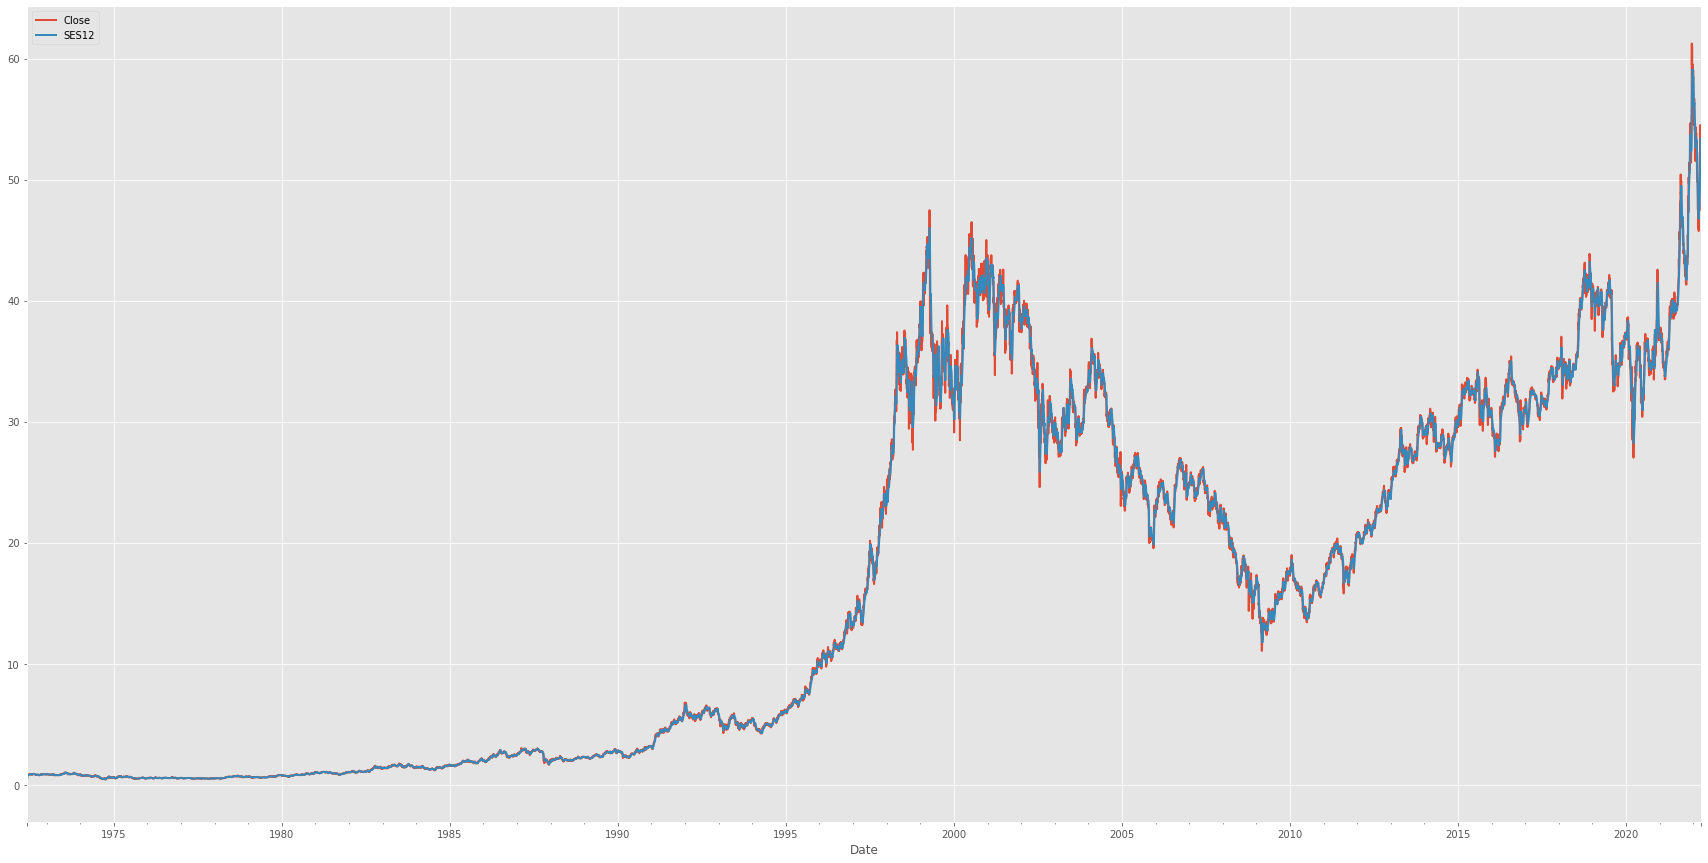

In [37]:
df[['Close',"SES12"]].plot(figsize=(30,15)).autoscale(axis='x',tight=True);


In [38]:
df['DESadd12'] = ExponentialSmoothing(df['Open'], trend='add').fit().fittedvalues.shift(-1)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA,EWMA12,SES12,DESadd12
Date,,,,,,,,,,,,,,
1972-06-01,0.000000,0.815346,0.802993,0.815346,0.171287,2458771.0,2.458774e+06,NaN,NaN,NaN,NaN,0.000000,0.000000,0.003608
1972-06-02,0.815346,0.817817,0.802993,0.805463,0.169211,1613885.0,1.613888e+06,-0.343621,NaN,NaN,0.407673,0.181188,0.181188,0.794062
1972-06-03,0.805463,0.807934,0.798051,0.802993,0.168692,2585251.0,2.585254e+06,0.601879,NaN,NaN,0.810404,0.319916,0.319916,0.808011
1972-06-04,0.805463,0.807934,0.798051,0.802993,0.168692,2585251.0,2.585254e+06,0.000000,NaN,NaN,0.805463,0.427815,0.427815,0.808426
1972-06-05,0.805463,0.807934,0.798051,0.802993,0.168692,2585251.0,2.585254e+06,0.000000,NaN,NaN,0.805463,0.511737,0.511737,0.808439


<AxesSubplot:xlabel='Date'>

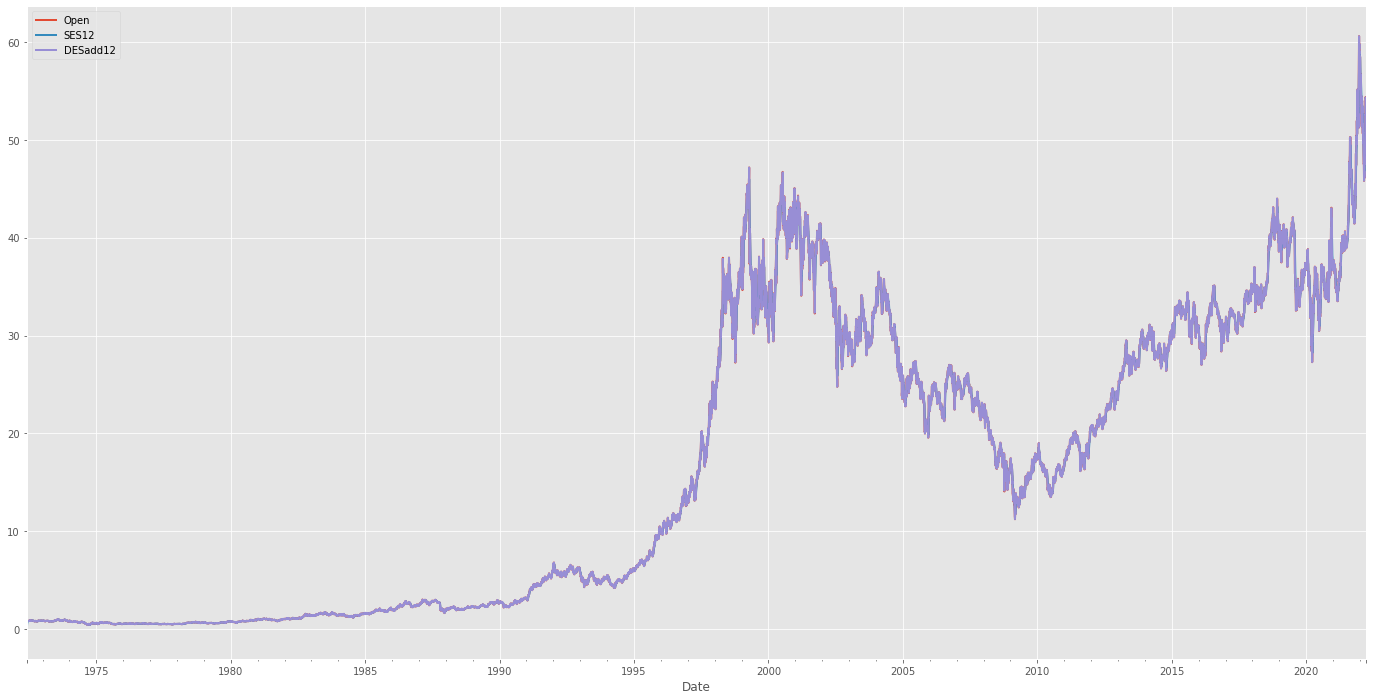

In [39]:
df[['Open',  'SES12', 'DESadd12']].plot(figsize=(24,12))

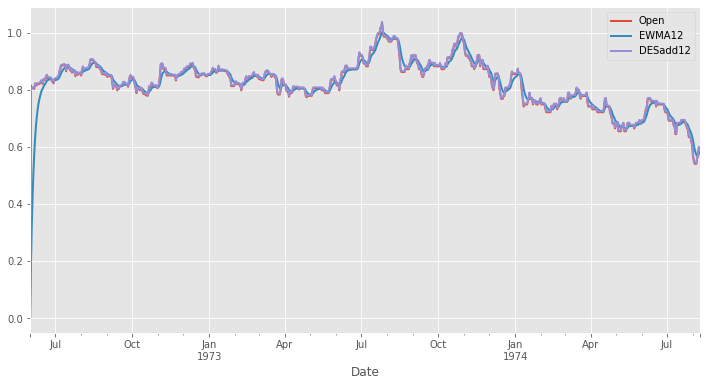

In [40]:
df[['Open','EWMA12','DESadd12']].iloc[:800].plot(figsize=(12,6)).autoscale(axis='x',tight=True);


# LSTM MODEL¶¶


In [41]:
data = df.filter(['Open'])

dataset = data.values

training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

17285

In [42]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.        ],
       [0.01345455],
       [0.01329147],
       ...,
       [0.89438948],
       [0.87491752],
       [0.86699674]])

In [43]:
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        

x_train, y_train = np.array(x_train), np.array(y_train)


x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.        , 0.01345455, 0.01329147, 0.01329147, 0.01329147,
       0.01325071, 0.01353611, 0.01353611, 0.01345455, 0.01353611,
       0.01353611, 0.01353611, 0.01357688, 0.01369919, 0.01369919,
       0.01353611, 0.01378073, 0.01378073, 0.01378073, 0.01394381,
       0.01402536, 0.01386228, 0.01390305, 0.01386228, 0.01386228,
       0.01386228, 0.01369919, 0.01365842, 0.01357688, 0.01378073,
       0.0138215 , 0.0138215 , 0.0138215 , 0.01394381, 0.01394381,
       0.01422921, 0.01439229, 0.01459616, 0.01459616, 0.01459616,
       0.01463693, 0.01463693, 0.01459616, 0.01426998, 0.01459616,
       0.01459616, 0.01459616, 0.01443307, 0.01431076, 0.01439229,
       0.01418845, 0.01426998, 0.01426998, 0.01426998, 0.01398459,
       0.01418845, 0.0141069 , 0.01406612, 0.01414767, 0.01414767])]
[0.014147673734246658]

[array([0.        , 0.01345455, 0.01329147, 0.01329147, 0.01329147,
       0.01325071, 0.01353611, 0.01353611, 0.01345455, 0.01353611,
       0.01353611, 0.01353611, 0.0

In [44]:
    model = Sequential()    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 40, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 30, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 20))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.summary()


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 40)            14560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 30)            8520      
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 30)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20)                4

In [45]:
callbacks = [EarlyStopping(patience=3, monitor='val_loss', mode='min'), 
             ReduceLROnPlateau(patience=2, verbose=1)]  

In [46]:
history =model.fit(x_train, y_train, 
                        epochs=10,
                        batch_size=128,
                        callbacks=[callbacks],
                        )

Epoch 1/10


2023-01-17 13:51:54.633499: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


135/135 [==============================] - 44s 267ms/step - loss: 0.0064
Epoch 2/10
135/135 [==============================] - 38s 278ms/step - loss: 0.0020
Epoch 3/10
135/135 [==============================] - 37s 272ms/step - loss: 0.0018
Epoch 4/10
135/135 [==============================] - 37s 271ms/step - loss: 0.0016
Epoch 5/10
135/135 [==============================] - 37s 272ms/step - loss: 0.0015
Epoch 6/10
135/135 [==============================] - 37s 271ms/step - loss: 0.0014
Epoch 7/10
135/135 [==============================] - 36s 270ms/step - loss: 0.0013
Epoch 8/10
135/135 [==============================] - 37s 276ms/step - loss: 0.0012
Epoch 9/10
135/135 [==============================] - 36s 265ms/step - loss: 0.0012
Epoch 10/10
135/135 [==============================] - 36s 266ms/step - loss: 0.0011


In [47]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))

In [48]:
mean_absolute_error(y_test, predictions)

1.4891056188563314

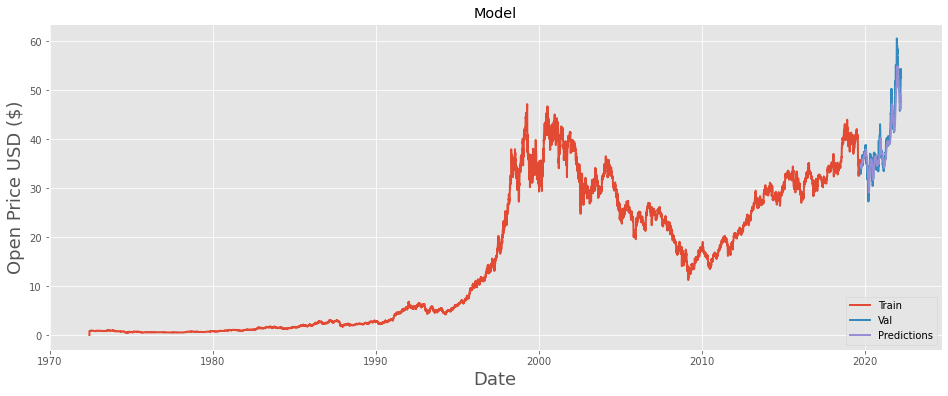

In [49]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [50]:
predictions = model.predict(x_test)


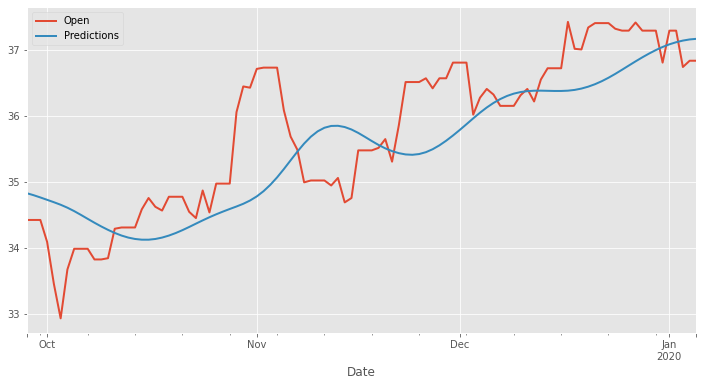

In [51]:
valid[['Open','Predictions']].iloc[:100].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [52]:
valid.head()


,Open,Predictions
Date,,
2019-09-28,34.421253,34.826183
2019-09-29,34.421253,34.796146
2019-09-30,34.421253,34.761871
2019-10-01,34.089184,34.726028
2019-10-02,33.453510,34.689777
